# 3. Aprendizaje Supervisado 


Realizaremos disintintos modelos de aprendizaje supervisado, ajustando sus hiperparametros para posteriormente ver cual de ellos  presenta un mejor desempeño. 



In [1]:
### LIMPIEZA DE DATOS 
import numpy as np
import pandas as pd

###VISUALIZACION DEL MODELO

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

Creamos una nueva variable que se  categorizará el precio en funcion de si es caro(1) o barato (0). 

In [2]:
# Hemos separado  el 70%

###DIVISION DE LOS DATOS----------------------------------------------- 

data= pd.read_csv("./CSV/csv_precio_div.csv")


# dividir el data set de forma aleatoria 

p_train = 0.70 # Porcentaje de train.

data['is_train'] = np.random.uniform(0, 1, len(data)) <= p_train
train, test = data[data['is_train']==True], data[data['is_train']==False]
df = data.drop('is_train', 1)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))


Ejemplos usados para entrenar:  15133
Ejemplos usados para test:  6521


### 3.1 GLM : Regresion Logística 




Seleccionamos las variables  seleccionada a raiz del PCA 'Distancia_NEW','Lattitude','Longtitude','Landsize' e intentamos predecir la variable categorizada del precio. 

In [3]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [4]:
#TRAIN 
features = np.array(train[['Distancia_NEW','Lattitude','Longtitude','Landsize']])
labels = np.array(train['precio_div'])

In [5]:
#TEST
features_t = np.array(test[['Distancia_NEW','Lattitude','Longtitude','Landsize']])
labels_t = np.array(test['precio_div'])

In [6]:
# Create logistic regression model

model = linear_model.LogisticRegression()

#Train the model
model.fit(features, labels)#The first is a matrix of features, and the second is a matrix of class labels. 

LogisticRegression()

Evaluamos como de bueno ha sido el ajuste del modelo sobre los propios datos de entrenamiento.  

In [7]:
predictions= model.predict(features)
print(accuracy_score(labels, predictions))

0.6254543051609066


Validamos el modelos usando los datos de test. 

In [8]:
#Validacion del modelo
predictions_t= model.predict(features_t)
print(accuracy_score(labels_t, predictions_t))

0.6316515871798803


Para obtener mas información sobre el modelo  procedemos a evaluar los resultados con un matriz de confusión  y un reporte de clasificación.  

#### 3.1.1. Evaluación del modelo de Regresión Logística

In [9]:
#Reporte de resultados del Modelo

print(classification_report(labels_t , predictions_t))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61      3138
           1       0.64      0.67      0.65      3383

    accuracy                           0.63      6521
   macro avg       0.63      0.63      0.63      6521
weighted avg       0.63      0.63      0.63      6521



Podemos observar que la distribución entre ambas categorias es bastante homogénea,  al igual que el acierto en la predicción de cada una de ellas es parecida aunque ligeramente superior en la categoría de casas caras. 

F1 score  es 0.62  un valor que  se puede considerar como aceptable, pero todavia tiene un amplio margen de mejora que seguramente alcanzaremos con otros modelos. 

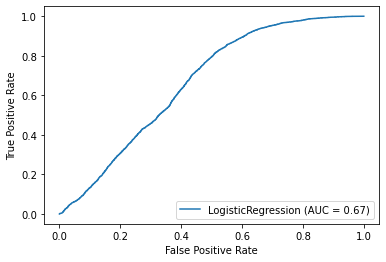

In [10]:
#dibujo de la Curva ROC

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

rlog_disp = plot_roc_curve(model, features, labels)
plt.show()


### 3.2. K- NEAREST NEIGHBORS (KNN )

Para realizar  el modelo de Knn primero al igual que en la regresion logistica separamos los datos en train y test. Tambien estandarizamos los datos para poder obtener  un mejor rendimiento del modelo. 

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [12]:
# # SELECCION DE VARIABLES

X = train[['Distancia_NEW','Lattitude','Longtitude','Landsize']].values
y = train['precio_div'].values

X_test=test[['Distancia_NEW','Lattitude','Longtitude','Landsize']].values
y_test=test['precio_div'].values
 

In [13]:
#NORMALIZACION
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)


#### 3.2.1. Ajuste de hiperparametros 

Con el objetivo de elegir el mejor número de vecinos dibujamos una gráfica con todas las variables en un rango entre 0 y 20. 

([<matplotlib.axis.XTick at 0x7feebb3a7a90>,
 <a list of 5 Text major ticklabel objects>)

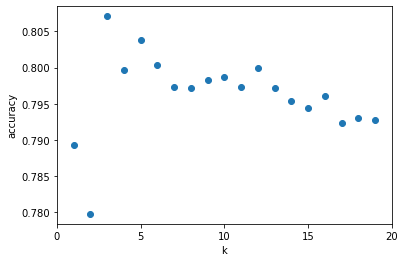

In [14]:
#ELEGIR EL MEJOR K 

k_range = range(1, 20)
scores = []
for k in k_range:
     knn = KNeighborsClassifier(n_neighbors = k)
     knn.fit(X, y)
     scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

Visualizando la gráfica anterior buscamos el valor de k que nos proporcione el mejor f1-score dentro del rango entre 1 y 10 vecinos. 

In [15]:

#encontrar la mejor k 

best_k=0
best_score=0
neighbors=range(1,10,2)#considerara min_k=1, max_k=10, solo odd numbers 
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k) #instantiante classifier
    knn.fit(X, y )# fit model 
    knn_y_pred= knn.predict(X_test)
    
    #we will consider the optimal k to be the k that produce the highest f1 score
    f1 = metrics.f1_score(y_test, knn_y_pred, pos_label=1)
    if f1> best_score:
        best_k= k 
        best_score =f1
        
print (best_k)

3


Obtenemos que el mejor valor para k y por lo tanto procedemos a  entrenar nuestro modelo con el. Este dato corresponde con la gráfica anteriormente  visualizada. 

#### 3.2.2 Evaluación del modelo de KNN

In [16]:
#Hiperparametros-
n_neighbors = best_k
#algorithm='brute'
#p=1
#weights='distance'# uniforme ( todos los puntos son iguales )
#n_jobs=-1

#train Knn

knn=  KNeighborsClassifier(n_neighbors) 
knn.fit(X, y )


#Medida de precision
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X, y)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.89


Accuracy of K-NN classifier on test set: 0.81


In [17]:
#PRECISION DEL MODELO

knn_y_pred= knn.predict(X_test)
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3138
           1       0.81      0.82      0.82      3383

    accuracy                           0.81      6521
   macro avg       0.81      0.81      0.81      6521
weighted avg       0.81      0.81      0.81      6521



Obtenemos un f1-score de 0.81 lo cual es bastante bueno. 

Representamos la curva ROC para ver como se comporta el modelo en relación a falsos positivos y  verdaderos positivos. La mejora es evidente con respecto a la regresion logistica. 

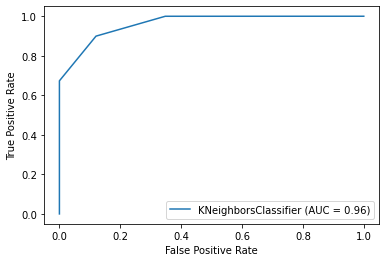

In [18]:
#Pintar curva ROC
Knn_disp = plot_roc_curve(knn, X, y)
plt.show()

### 3.3. Maquina de Vectore de Soporte (SVM). 

Sobre los datos normalizados aplicamos  diferentes kernels para obserbar cual de ellos se ajusta mejor a los datos. 
Podemos visualizar que claramente el que tiene un rendimiento mas alto es el Kernel radial. 

In [19]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

In [20]:
X = train[['Distancia_NEW','Lattitude','Longtitude','Landsize']].values
y = train['precio_div'].values

X_test=test[['Distancia_NEW','Lattitude','Longtitude','Landsize']].values
y_test=test['precio_div'].values


Realizamos el modelo de SVM con los tres tipos de Kernel  más comunes Lineal, polinomico y rbf. Los tres con los mismos valores de C para evaluar cual tiene mejor resultado. 

In [21]:
#NORMALIZACION

scaler = preprocessing.StandardScaler().fit(X)
X_norm = scaler.transform(X)
X_test_norm = scaler.transform(X_test)

#### Kernel Lineal 

In [22]:
#classifier = SVC(kernel = "linear", C = 2)
#classifier.fit(X_norm, y) 
#classifier.predict(X_test_norm)
#print("Kernel lineal", classifier.score(X_test_norm, Y_test))

#### Kernel Polinómico

In [23]:
#classifier = SVC(kernel = "poly",degree= 2, C = 2)
#classifier.fit(X_norm, y) 
#print(classifier.predict(X_test))
#print("Kernel polinómico", classifier.score(X_test_norm, Y_test))

#### Kernel Radial

El modelo que mejor resultado obtiene es el propuesto con kernel radial.

In [24]:

#Prediccion con datos normalizados 

classifier = SVC(kernel = "rbf", gamma = 0.3, C = 2)
classifier.fit(X_norm, y) 
#print(classifier.predict(X_test))
print(" Kernel rbf con datos normalizados: ", classifier.score(X_test_norm, y_test))

 Kernel rbf con datos normalizados:  0.7294893421254409


#### 3.1.Ajuste de hiperparametros

Hemos obtenido que normalizando los datos y usando el Kernel radial obtenemos los mejores resultados, partiremos de esa base para el cálculo de hiperparámetros.

Aplicamos esta técnica para probar diferentes C y Gammas. 

Seleccionamos unos parametros de C y gamma dentro del rango de los valores mas comunes. Aplicamos el modelo usando esta combinacion de los datos de tal manera que  obtenemos la combinacion mas optima. 

In [25]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define model and parameters
model = SVC()
kernel = ['rbf']
C = [50,10, 1.0, 0.1, 0.01]
gamma= [0.001,0.01,0.1,1]


# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)#cv=cv
grid_result = grid_search.fit(X_norm, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [26]:
# Hiperparametros seleccionados 
classifier = SVC(kernel = "rbf", gamma = 1, C = 50)
classifier.fit(X_norm, y) 
#print(classifier.predict(X_test))
print(" Kernel rbf con ajuste de hiperparametros: ", classifier.score(X_test_norm, y_test))

 Kernel rbf con ajuste de hiperparametros:  0.7956226880394575


Tras el ajuste de los hiperparámetros el resultado obtenido por svm  alcanza  un porcetaje muy elevado. Entorno a un 0.80 se puede considerar que es un modelo con buenos resultados. 

In [27]:
#PRECISION DEL MODELO
pred = classifier.predict(X_test_norm)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      3229
           1       0.78      0.83      0.80      3259

    accuracy                           0.80      6488
   macro avg       0.80      0.80      0.80      6488
weighted avg       0.80      0.80      0.80      6488



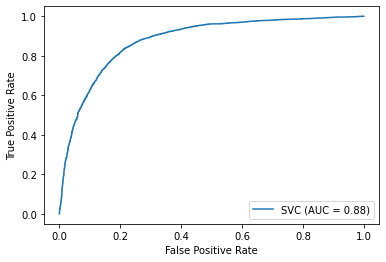

In [28]:
svm_roc = plot_roc_curve(classifier, X_norm, y)
plt.show()